<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/autoencoders/DUDL_autoenc_occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For DL modeling
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch.nn as nn

# For number-crunching
import numpy as np
import scipy.stats as stats

# For dataset management
import pandas as pd
from sklearn.model_selection import train_test_split

# For data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
import seaborn as sns

# For timing computations
import time

import copy

import sklearn.metrics as skm

import sys

# Import and process the data

In [2]:
# Import dataset
mnist_dataset = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'), delimiter=',')

#Extract labels (number IDs) and remove from data
labels = mnist_dataset[:, 0]
data   = mnist_dataset[:, 1:]

# Normalize the data to a range of [0, 1]
data_norm = data / np.max(data)

# Convert to tensor
data_tensor   = torch.tensor(data_norm).float()

# Demonstration of implementing occlusion

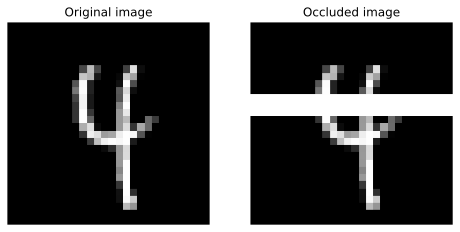

In [3]:
# Reconstruct a sample as an image

img = data_tensor[12345, :].view(28, 28)

occluded = copy.deepcopy(img)
occluded[10:13, :] = 1

fig, ax = plt.subplots(1, 2, figsize=(8, 5))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(occluded, cmap='gray')
ax[1].set_title('Occluded image')
ax[1].axis('off')

plt.show()

# Create the DL model

In [4]:
# Create a class for the model
def create_the_MNIST_AE():
    """
    AUTO_ENCODER_OCCLUSION
    """
    class ae_net(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 128)

            # Encoder layer
            self.enc = nn.Linear(128, 50)

            # Latent layer
            self.lat = nn.Linear(50, 128)

            # Decoder layer
            self.dec = nn.Linear(128, 784)
    
        # Forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x))

            return y
    
    # Create the model instance
    net = ae_net()

    # Loss function
    loss_func = nn.MSELoss()

    # Optimizer
    optimizer = torch.optim.Adam(params=net.parameters(), lr=0.001)

    return net, loss_func, optimizer

# Create a function that trains the model

In [5]:
def train_the_model():
    """
    AUTO_ENCODER_OCCLUSION
    """

    num_epochs = 5

    # Create a new model
    net, loss_func, optimizer = create_the_MNIST_AE()

    # Initialize losses
    losses = []

    # Batch size and number of batches
    batch_size = 32
    num_batch  = int(data_tensor.shape[0] / batch_size)

    # Loop over epochs
    for epoch_i in range(num_epochs):

        # Get a permuted index vector
        rand_idx = np.random.permutation(data_tensor.shape[0]).astype(int)

        # Lossed during batches
        batch_losses = []

        for batch_i in range(num_batch):

            # Samples to use in this batch
            samps_2_use = range((batch_i - 1) * batch_size, batch_i * batch_size)

            # Select those images
            X = data_tensor[rand_idx[samps_2_use], :]

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, X)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Losses in this batch
            losses.append(loss.item())

        # End minibatch loop
    
    # End epochs
    
    # Function output
    return losses, net

# Run the model and show the results!

Final loss: 0.0123


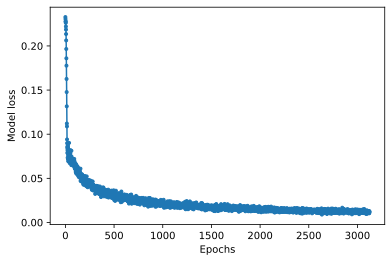

In [6]:
# Train the model
losses, net = train_the_model()
print(f'Final loss: {losses[-1]:.4f}')

# Visualize the losses
plt.plot(losses, '.-')
plt.xlabel('Epochs')
plt.ylabel('Model loss')
plt.show()

# Add occlusion to some images

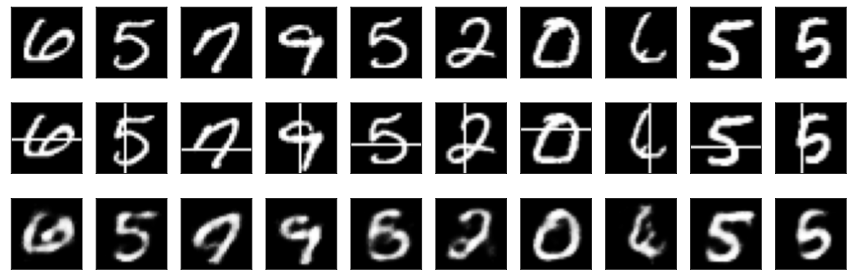

In [8]:
# Grab a small set of image
X = copy.deepcopy(data_tensor[:10, :])

# Add noise
for i in range(X.shape[0]):

    # Reshape the image
    img = X[i, :].view(28, 28)

    # Occlude random rows or columns
    start_loc = np.random.choice(range(10, 21))

    # Even -> Horizontal occlusion
    if (i % 2 == 0):
        img[start_loc:start_loc + 1, :] = 1
    # Odd -> Vertical occlusion
    else:
        img[:, start_loc:start_loc + 1] = 1
    
# Run the samples through the model
de_occluded = net(X)

# Show the noisy images
fig, axs = plt.subplots(3, 10, figsize=(15, 5))

for i in range(10):
    axs[0, i].imshow(data_tensor[i, :].view(28, 28).detach(), cmap='gray')
    axs[1, i].imshow(X          [i, :].view(28, 28).detach(), cmap='gray')
    axs[2, i].imshow(de_occluded[i, :].view(28, 28).detach(), cmap='gray')
    axs[0, i].set_xticks([]), axs[0, i].set_yticks([])
    axs[1, i].set_xticks([]), axs[1, i].set_yticks([])
    axs[2, i].set_xticks([]), axs[2, i].set_yticks([])

plt.show()

# Something more quantitative

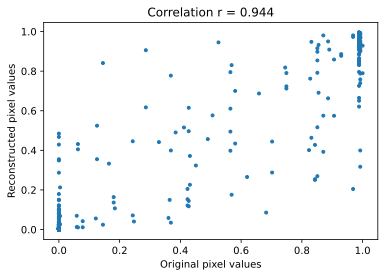

In [9]:
# Quantify the performance of the "de-occluder" by correlating the sample with the original

in_out_corr = np.corrcoef(data_tensor[9, :].detach(), de_occluded[9, :].detach())

plt.plot(data_tensor[9, :].detach(), de_occluded[9, :].detach(), '.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r = {in_out_corr[0, 1]:.3f}')
plt.show()

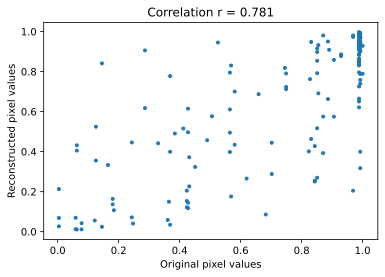

In [10]:
# Try again without the zero-valued pixels
# Extract to variables for convenience
orig  = data_tensor[9, :].detach()
recon = de_occluded[9, :].detach()

# Boolean vector that indicates pixels>0 (with some tolerance)
tol             = 1e-4
non_zero_pixels = (orig > tol) & (recon > tol)

# Then re-compute the correlation
in_out_corr = np.corrcoef(orig[non_zero_pixels], recon[non_zero_pixels])

plt.plot(orig[non_zero_pixels], recon[non_zero_pixels], '.')
plt.xlabel('Original pixel values')
plt.ylabel('Reconstructed pixel values')
plt.title(f'Correlation r = {in_out_corr[0, 1]:.3f}')
plt.show()

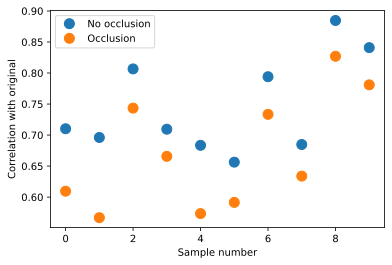

In [11]:
# Get data with no occlusion
no_occlusion = net(data_tensor[:10, :])

# Compare deoccluded-original to noocclusion-original correlation
r = np.zeros((10, 2))
for i in range(de_occluded.shape[0]):

    # Pixel selection (note: tolerance defined in previous cell)
    non_zero_pixels = (data_tensor[i, :] > tol) & (no_occlusion[i, :] > tol) & (de_occluded[i, :] > tol)

    # Now compute the correlations
    r[i, 0] = np.corrcoef(data_tensor[i, non_zero_pixels].detach(), no_occlusion[i, non_zero_pixels].detach())[0, 1]
    r[i, 1] = np.corrcoef(data_tensor[i, non_zero_pixels].detach(), de_occluded [i, non_zero_pixels].detach())[0, 1]

# Plot the correlation coefficients
plt.plot(r, 'o', markersize=10)
plt.legend(['No occlusion', 'Occlusion'])
plt.xlabel('Sample number')
plt.ylabel('Correlation with original')
plt.show()

# Additional explorations
1) Does occlusion affect some numbers more than others? Run the entire dataset through the autoencoder with occluded
   images. Compute the image correlations for each sample. Then compute the average correlation for each number (image
   label). Show the results in a plot. (Bonus: Also compute the standard deviation across correlations and use those
   to draw error bars.) What do the results tell you about the difficulty of fixing occlusions in images?

2) Perhaps a correlation coefficient isn't really the best performance metric. Try this: Binarize the images like we 
   did in the video "CodeChallenge: Binarized MNIST images" (section FFN). Then compute the number of pixels in the 
   original and reconstructed images that overlap (hint: try summing them). Make sure your new metric has a possible
   range of 0 (absolutely no overlap) to 1 (perfect overlap). Does this metric seem more consistent with your visual
   intuition?

3) But wait a minute, don't we already have a quantitative measure of the similarity between the AE input and output?
   Of course we do -- it's the loss function! Mean-squared error already accounts for zeros because those get ignored
   [zero-valued pixels have MSE=(0-0)**2 ]. In fact, question #2 is kindof a "rough MSE." Take a moment to write down
   the formulas for MSE and correlation, and see whether they are related (hint: the relationship isn't linear because of
   the squared term). Finally, compute MSE on our example occlusion images and compare MSE to correlation empirically
   by making a scatter plot. (Hint 1: Use more than 10 examples to see trends. Hint 2: Consider the signs (+/-).)

Note about exercises 2&3: MSE really is the best loss function for this problem. The purpose of these exercises is to
   get you thinking critically about autoencoders, loss functions, and the idea of using custom-designed quantitative
   comparisons measures. I hope you find these problems enjoyable and thought-provoking!